In [1]:
import requests
import numpy as np
from config import *
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import os
import json

from dateutil.relativedelta import relativedelta
from docopt import docopt #해당 모듈을 어떻게 쓸지 자동으로 알려 줌
from warnings import filterwarnings

filterwarnings('ignore')

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# font_path = "C:/Windows/Fonts/malgun.ttf"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)
# plt.rcParams['axes.unicode_minus'] = False


In [2]:
def df_plotting(df, title='Insert Title'):

    column_idx = df.columns.to_list()
    time_idx = df.index.to_list()

    plt.figure(figsize=(20,12), facecolor='w')
    
    color_sequence = ['b', 'r', 'yellow', 'g', 'm', 'purple', "navy", 'orange', 'pink']

    for idx, i in enumerate(column_idx):
        plt.plot(time_idx, df[i], color=color_sequence[idx], label=i, linewidth=1.2)

    plt.title(title, size=30)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=15, rotation=30)
    plt.yticks(fontsize=15)
    plt.show()

In [3]:
def daily_news_df(date_from, date_to):
    
    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    #date_interval = list(pd.date_range(dt.datetime.strptime(date_from, '%Y-%m-%d'), dt.datetime.strptime(date_to, '%Y-%m-%d'), freq='d'))  

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    query_day = {
        "size": 0,
            "query":{
                "range":{
                "created_at": {
                    "gte": date_from,
                    "lte": date_to
                    }
                }
            },
            "aggs": {
                "group_by_date":{
                "date_histogram": {
                    "field": "created_at",
                    "interval": "day"
                }
            }
        }
    }

    headers = {
        'Content-Type' : 'application/json'
    }

    resp = requests.get(
        url,
        data=json.dumps(query_day),
        headers=headers,
        auth= ELASTIC_SEARCH_AUTH
    )

    data = resp.json()

    daily = data['aggregations']['group_by_date']['buckets']
    df_daily = pd.DataFrame(data = daily)[['key_as_string', 'doc_count']]
    df_daily = df_daily.rename(columns={"key_as_string" : "date"})
    df_daily['date'] = pd.to_datetime(df_daily['date'])
    df_daily = df_daily.set_index('date')

    return df_daily

In [4]:
df = daily_news_df("2022-05-01", "2022-05-31")

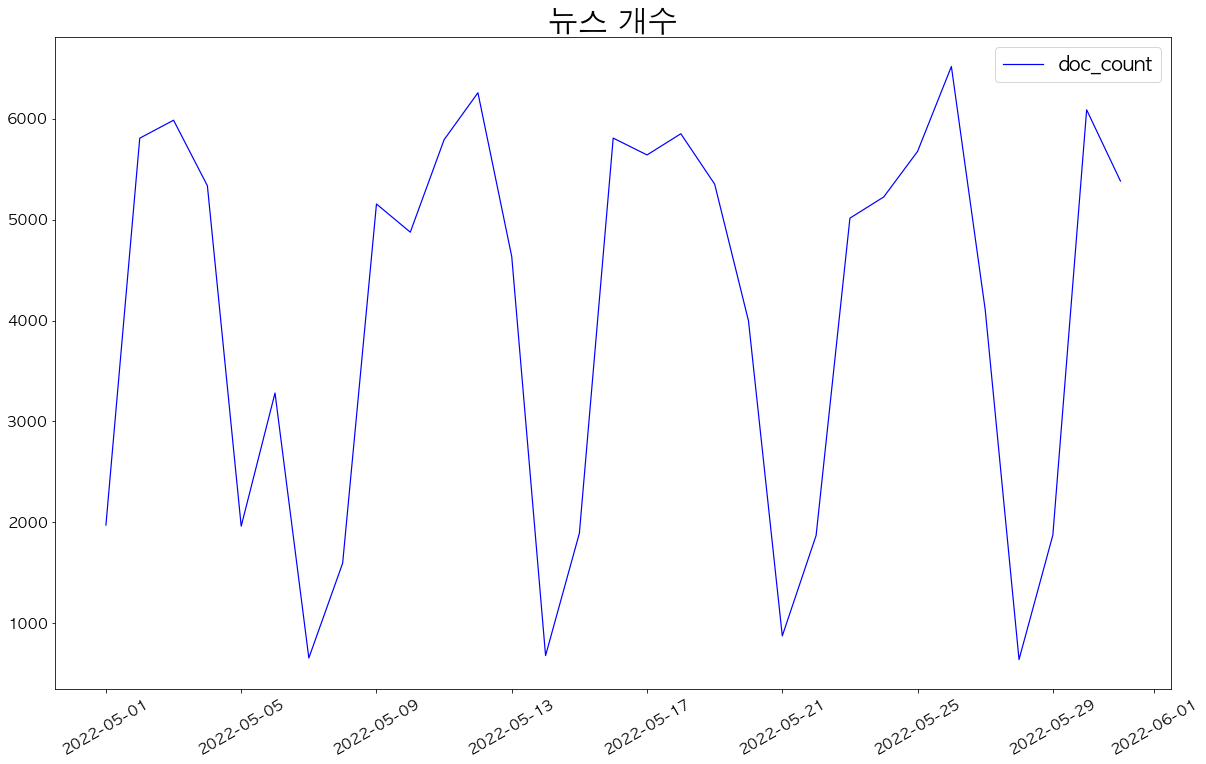

In [5]:
df_plotting(df, "뉴스 개수")

In [6]:
df

,doc_count
date,
2022-05-01 00:00:00+00:00,1974
2022-05-02 00:00:00+00:00,5806
2022-05-03 00:00:00+00:00,5984
2022-05-04 00:00:00+00:00,5335
2022-05-05 00:00:00+00:00,1963
2022-05-06 00:00:00+00:00,3282
2022-05-07 00:00:00+00:00,657
2022-05-08 00:00:00+00:00,1596
2022-05-09 00:00:00+00:00,5154


# 2. Top5 언론사 리스트 변수로 받아 각 날짜 별로 언론사 기사 갯수 time-series chart 출력

## Top5 언론사

In [7]:
def top_publisher(num_of_publisher, date_from, date_to):
    
    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    query_publisher = {
    "size": 0,
        "query":{
            "range":{
                "created_at": {
                    "gte": date_from,
                    "lte": date_to
                    }
                }
            },
    "aggs": {
        "group_by_publisher":{
            "terms": {
                "field": "publisher.keyword",
                "size": num_of_publisher
                }
            }
        }
    }

    headers = {
        'Content-Type' : 'application/json'
    }

    resp = requests.get(
        url,
        data=json.dumps(query_publisher),
        headers=headers,
        auth= ELASTIC_SEARCH_AUTH
    )

    data = resp.json()

    dict = data['aggregations']['group_by_publisher']['buckets']

    df = pd.DataFrame(data=dict)

    # publisher_list = []
    # for i in range(len(dict)):
    #     publisher_list.append(dict[i]['key'])

    return df['key'].to_list()

In [9]:
top_publisher(5, "2022-05-01", "2022-05-31")

['뉴스1', '뉴시스', '연합뉴스', '이데일리', '파이낸셜뉴스']

In [8]:
def publisher_daily_news_trend (publisher_list, date_from, date_to):
    
    time_idx = daily_news_df(date_from, date_to).index.to_list()

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    df = pd.DataFrame(index=time_idx)

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    headers = {
    'Content-Type' : 'application/json'
    }


    for keyword in publisher_list:
        query = {
            "size": 0,
            "query":{
                "range":{
                    "created_at": {
                        "gte": date_from,
                        "lte": date_to
                        }
                    }
                },
                "aggs": {
                    "group_by_date":{
                        "date_histogram": {
                            "field": "created_at",
                            "interval": "day"
                        }
                    }
                },
                "query":{
                    "match":{
                    "publisher": keyword
                    }
                }
        }
        
        resp = requests.get(
            url,
            data=json.dumps(query),
            headers=headers,
            auth= ELASTIC_SEARCH_AUTH
        )

        data = resp.json()
        data = data['aggregations']['group_by_date']['buckets']
        df_tmp = pd.DataFrame(data = data)[['key_as_string', 'doc_count']]
        df_tmp = df_tmp.rename(columns={"key_as_string" : "date"})
        df_tmp['date'] = pd.to_datetime(df_tmp['date'])
        df_tmp = df_tmp.set_index('date')

        df[keyword] = df_tmp['doc_count']


    return df
    

In [10]:
publisher_daily_news_trend(top_publisher(5, "2022-05-01", "2022-05-31"), "2022-05-01", "2022-05-31")

,뉴스1,뉴시스,연합뉴스,이데일리,파이낸셜뉴스
2022-05-01 00:00:00+00:00,217,161,178,136,128
2022-05-02 00:00:00+00:00,471,500,406,443,353
2022-05-03 00:00:00+00:00,528,580,461,494,316
2022-05-04 00:00:00+00:00,501,403,403,400,293
2022-05-05 00:00:00+00:00,116,128,162,100,99
2022-05-06 00:00:00+00:00,279,284,263,278,123
2022-05-07 00:00:00+00:00,45,50,39,48,26
2022-05-08 00:00:00+00:00,104,103,125,89,110
2022-05-09 00:00:00+00:00,446,420,378,385,288
2022-05-10 00:00:00+00:00,390,393,375,414,287


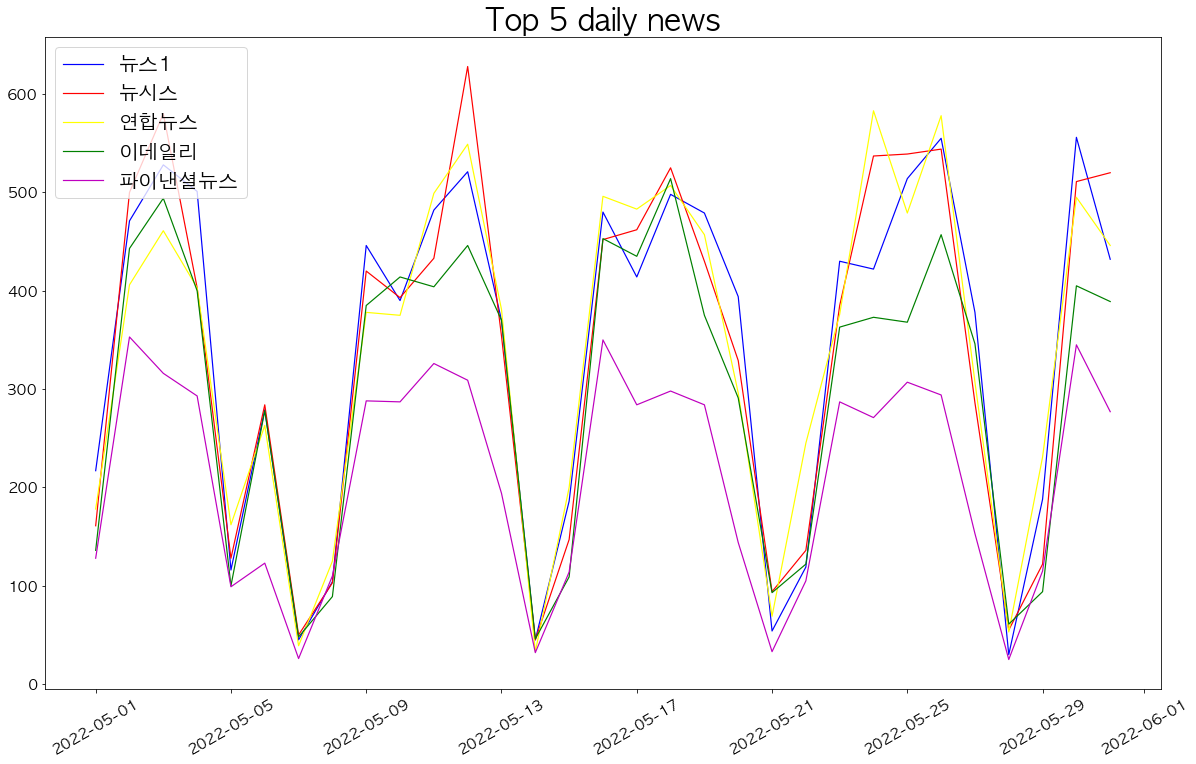

In [11]:
df_plotting(publisher_daily_news_trend(top_publisher(5, "2022-05-01", "2022-05-31"), "2022-05-01", "2022-05-31"),"Top 5 daily news")

# 3. 키워드 리스트를 변수로 받아 키워드별 일별 기사 갯수 & 비율 출력

In [12]:
def keyword_daily_news_trend (keyword_list, date_from, date_to):

    time_idx = daily_news_df(date_from, date_to).index.to_list()

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    df = pd.DataFrame(index=time_idx)

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    headers = {
    'Content-Type' : 'application/json'
    }


    for keyword in keyword_list:
        query = {
                "size": 0,
                    "query":{
                        "range":{
                        "created_at": {
                            "gte": date_from,
                            "lte": date_to
                            }
                        }
                },
                "aggs": {
                    "group_by_date":{
                        "date_histogram": {
                            "field": "created_at",
                            "interval": "day"
                        }
                    }
                },
                "query":{
                    "match":{
                    "body": keyword
                    }
                }
            }

        resp = requests.get(
            url,
            data=json.dumps(query),
            headers=headers,
            auth= ELASTIC_SEARCH_AUTH
        )

        data = resp.json()
        data = data['aggregations']['group_by_date']['buckets']
        df_tmp = pd.DataFrame(data = data)[['key_as_string', 'doc_count']]
        df_tmp = df_tmp.rename(columns={"key_as_string" : "date"})
        df_tmp['date'] = pd.to_datetime(df_tmp['date'])
        df_tmp = df_tmp.set_index('date')

        df[keyword] = df_tmp['doc_count']

    
    df = df.fillna(0)

    return df
    

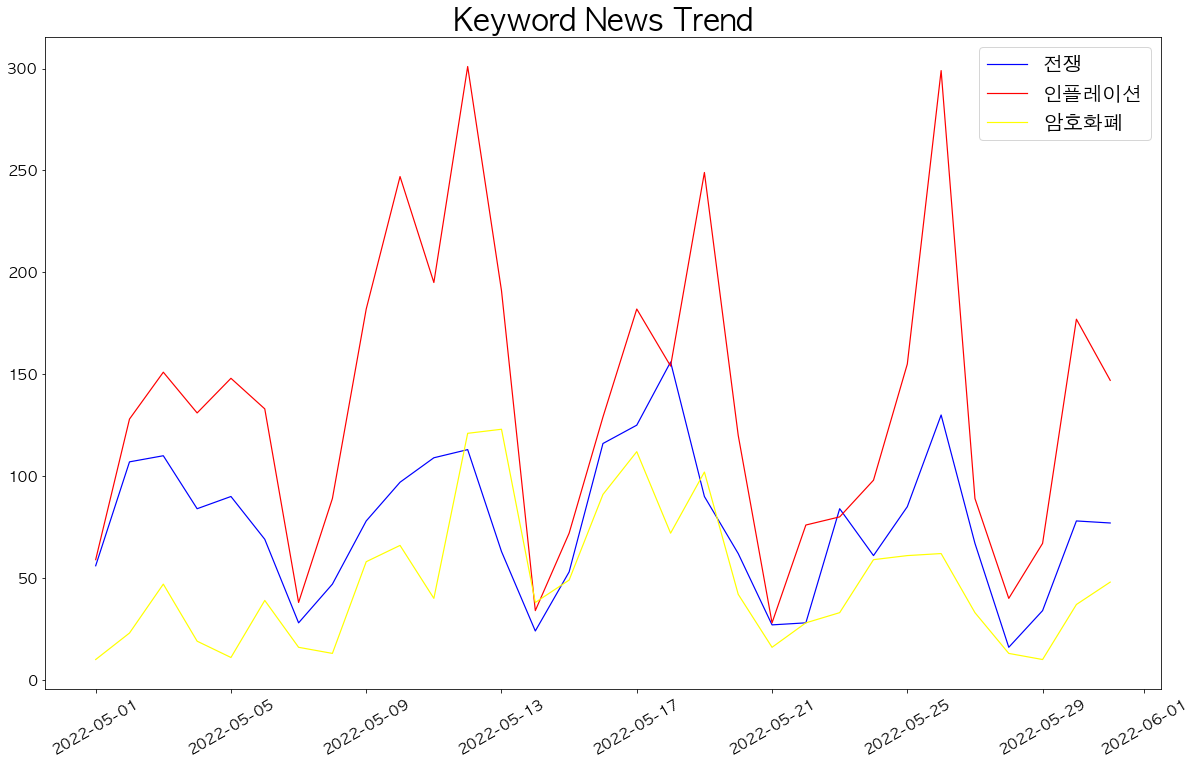

In [13]:
df_plotting(keyword_daily_news_trend(['전쟁', '인플레이션', '암호화폐'], "2022-05-01", "2022-05-31"), "Keyword News Trend")

In [14]:
keyword_daily_news_trend(['전쟁', '인플레이션', '암호화폐'], "2022-05-01", "2022-05-31")

,전쟁,인플레이션,암호화폐
2022-05-01 00:00:00+00:00,56,59,10
2022-05-02 00:00:00+00:00,107,128,23
2022-05-03 00:00:00+00:00,110,151,47
2022-05-04 00:00:00+00:00,84,131,19
2022-05-05 00:00:00+00:00,90,148,11
2022-05-06 00:00:00+00:00,69,133,39
2022-05-07 00:00:00+00:00,28,38,16
2022-05-08 00:00:00+00:00,47,89,13
2022-05-09 00:00:00+00:00,78,182,58
2022-05-10 00:00:00+00:00,97,247,66


# 4. 날짜별로 뉴스 Title 크롤링해서 리스트로 정리

In [15]:
def fetch_news_docs(date_from, date_to, page):
    
    date_from = date_from.isoformat()[0:10]
    date_to = date_to.isoformat()[0:10]

    query = {
        "query": {
            "range":{
                "created_at": {
                    "gte": date_from,
                    "lte": date_to
                }
            }
        },
        "size": 10,
        "from": page * 10
    }

    headers = {
        'Content-Type': 'application/json'
    }

    resp = requests.get(
        f'{ELASTIC_SEARCH_URL}/news/_search',
        headers = headers,
        data = json.dumps(query),
        auth = ELASTIC_SEARCH_AUTH
    )

    assert resp.status_code == 200

    data = json.loads(resp.text)
    hits = data['hits']['hits']

    return hits

def get_titles(hits):

    return hits['_source']['title']

def download_total_title (date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    # print("Downloading data from OpenSearch server")

    total_title_list = []

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        # print(f"{str_date} Start!")

        daily_title_list = []

        start_date = date_interval[i]
        end_date = date_interval[i] + relativedelta(days=1)

        for page in range(1000):

#            print('.', end='', flush=True)

            hits = fetch_news_docs(start_date, end_date, page)

            if len(hits) == 0:
                break

            for doc in hits:
            
                daily_title_list.append(get_titles(doc))

        total_title_list.append(daily_title_list)

        # print("***" + str_date + "End!" + "***")

    # print("Daily Data end!")

    return total_title_list

def total_title_show (total_title_list, date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        print(str_date)
        print(total_title_list[i] + '\n')

    #return date_interval

def txt_title_save (total_title_list, date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    with open('title_list_allday.txt','w',encoding='UTF-8') as f:

        for i in range(len(total_title_list)):
        
            str_date = date_interval[i].strftime('%Y-%m-%d')

            f.write('\n' + '[' + str_date + ']' + '\n\n')
        
            for titles in total_title_list[i]:

                f.write(titles + '\n')

In [16]:
def fetch_news_docs(date_from, date_to, page):
    
    date_from = date_from.isoformat()[0:10]
    date_to = date_to.isoformat()[0:10]

    query = {
        "query": {
            "range":{
                "created_at": {
                    "gte": date_from,
                    "lte": date_to
                }
            }
        },
        "size": 10,
        "from": page * 10
    }

    headers = {
        'Content-Type': 'application/json'
    }

    resp = requests.get(
        f'{ELASTIC_SEARCH_URL}/news/_search',
        headers = headers,
        data = json.dumps(query),
        auth = ELASTIC_SEARCH_AUTH
    )

    assert resp.status_code == 200

    data = json.loads(resp.text)
    hits = data['hits']['hits']

    return hits

def get_titles(hits):

    return hits['_source']['title']

def download_total_title (date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    # print("Downloading data from OpenSearch server")

    total_title_list = []

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        # print(f"{str_date} Start!")

        daily_title_list = []

        start_date = date_interval[i]
        end_date = date_interval[i] + relativedelta(days=1)

        for page in range(1000):

#            print('.', end='', flush=True)

            hits = fetch_news_docs(start_date, end_date, page)

            if len(hits) == 0:
                break

            for doc in hits:
            
                daily_title_list.append(get_titles(doc))

        total_title_list.append(daily_title_list)

        # print("***" + str_date + "End!" + "***")

    # print("Daily Data end!")

    return total_title_list

def total_title_show (total_title_list, date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        print(str_date)
        print(total_title_list[i] + '\n')

    #return date_interval

def txt_title_save (total_title_list, date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    with open('title_list_allday.txt','w',encoding='UTF-8') as f:

        for i in range(len(total_title_list)):
        
            str_date = date_interval[i].strftime('%Y-%m-%d')

            f.write('\n' + '[' + str_date + ']' + '\n\n')
        
            for titles in total_title_list[i]:

                f.write(titles + '\n')

In [20]:
#daily_news_title = download_total_title('2022-05-01', '2022-05-31')

In [21]:
#daily_news_title

In [22]:
#txt_title_save(daily_news_title, '2022-05-01', '2022-05-31')

In [17]:
def fetch_news_docs_keyword(date_from, date_to, page, keyword):
    
    date_from = date_from.isoformat()[0:10]
    date_to = date_to.isoformat()[0:10]

    query = {
        "query": {
            "bool": {
                "must":[
                    {
                        "match":{
                            "body": keyword
                        }
                    },
                    {
                    "range":{
                        "created_at": {
                            "gte": date_from,
                            "lt": date_to
                            }
                        }
                    }
                ]
            },
        },
        "size": 10,
        "from": page * 10
    }

    headers = {
        'Content-Type': 'application/json'
    }

    resp = requests.get(
        f'{ELASTIC_SEARCH_URL}/news/_search',
        headers = headers,
        data = json.dumps(query),
        auth = ELASTIC_SEARCH_AUTH
    )

    assert resp.status_code == 200

    data = json.loads(resp.text)
    hits = data['hits']['hits']

    return hits

def get_bodies(hits):

    return hits['_source']['body']


def download_total_title_keyword (date_from, date_to, keyword):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    # print("Downloading data from OpenSearch server")

    total_title_list = []

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        # print(f"{str_date} Start!")

        daily_title_list = []

        start_date = date_interval[i]
        end_date = date_interval[i] + relativedelta(days=1)

        for page in range(1000):

#            print('.', end='', flush=True)

            hits = fetch_news_docs_keyword(start_date, end_date, page, keyword)

            if len(hits) == 0:
                break

            for doc in hits:
            
                daily_title_list.append(get_titles(doc))

        total_title_list.append(daily_title_list)

        # print("***" + str_date + "End!" + "***")

    # print("Daily Data end!")

    return total_title_list

def download_total_bodies_keyword (date_from, date_to, keyword):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    # print("Downloading data from OpenSearch server")

    total_title_list = []

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        # print(f"{str_date} Start!")

        daily_title_list = []

        start_date = date_interval[i]
        end_date = date_interval[i] + relativedelta(days=1)

        for page in range(1000):

#            print('.', end='', flush=True)

            hits = fetch_news_docs_keyword(start_date, end_date, page, keyword)

            if len(hits) == 0:
                break

            for doc in hits:
            
                daily_title_list.append(get_bodies(doc))

        total_title_list.append(daily_title_list)

        # print("***" + str_date + "End!" + "***")

    # print("Daily Data end!")

    return total_title_list



In [18]:
key_list = download_total_title_keyword('2022-05-01', '2022-05-01', "삼성전자")

In [19]:
key_list

[['삼성전자 상반기 C랩 스핀오프 론칭데이',
  "'성공을 기원합니다'",
  "'필로토' 창업자 응원하는 박학규 사장",
  '삼성전자, 상반기 C랩 스핀오프 론칭데이',
  "삼성전자, '에듀테크' 관련 C랩 과제 2개 스타트업 창업 지원",
  "삼성전자, 에버랜드서 3년만에 오프라인 '갤럭시 팬파티'",
  '대-중소기업 임금 양극화 심한데…삼성전자 노조 “돈 더 달라” 몽니',
  '웨이퍼 들었던 바이든, 삼성 반도체 공장 방문하나…기대감↑',
  '삼성전자, AI 온라인 시험 감독 등 에듀테크 스타트업 창업 지원',
  "삼성, 모바일 AP 점유율 '반토막'…파운드리도 18%서 정체",
  'AI로 온라인 시험 부정 잡는다..삼성이 지원하는 사내벤처는?',
  "삼성전자, hy·삼성카드와 '비스포크 큐커' 할인행사",
  '"AI가 시험 감독"…삼성전자, 사내벤처 2곳 \'픽\'',
  "삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인",
  "삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인",
  "삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인",
  "삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인",
  "삼성전자, '에듀테크' 관련 C랩 과제 2개 스타트업 창업 지원",
  "삼성전자, '에듀테크' 관련 C랩 과제 2개 스타트업 창업 지원",
  '韓 반도체, “공급망 재편서 살아남으려면 美 동맹 참여해야”',
  '삼성전자, `우리집 전자레인지, 큐커로 교체해요` 2차 캠페인 진행…hy와 협업',
  '‘지역화폐 지원’ 삼성페이, 지역경제 활성화 나선다',
  "삼성전자 파운드리 출범 5년…공존하는 '기회와 위기'",
  "삼성전자, '에듀테크' 관련 C랩 과제 2개 스타트업 창업 지원",
  '"三電, 이재용 부회장 빈자리 크다"…커지는 사면복권 목소리',
  '삼성전자, 에듀테크 관련 C랩 과제 2개 스타트업 창업 지원',
  "에버랜드에 모인 '갤럭시 찐팬들'

# 각 날짜별로 주요 이슈 Top 3 요약

In [20]:
import nltk
import datetime as dt
import pdb

from collections import defaultdict
from sklearn.pipeline import Pipeline

from es_corpus_reader import EsCorpusReader
from korean_text_normalizer import KoreanTextNormalizer
from gensim_vectorizer import GensimTfidVectorizer
    
def classification_top_n(count_dict, n=3):
    
    for group in range(len(count_dict)):
        count_dict[group].sort()

    top_n = dict(sorted(count_dict.items(), reverse=True, key=lambda x: len(x[1]))[:n])

    i = 1

    for key in top_n.keys():
    
        print(f"*** TOP {i} Section ***")
        
        for idx, content in enumerate(top_n[key]):
            
            if idx < 5:
                print(f"{content}")
            else:
                pass
        i += 1

def classification_top_1(count_dict, n=1):
    
    for group in range(len(count_dict)):
        count_dict[group].sort()

    top_n = dict(sorted(count_dict.items(), reverse=True, key=lambda x: len(x[1]))[:n])

    i = 1

    for key in top_n.keys():
        
        for idx, content in enumerate(top_n[key]):
            
            if idx < 5:
                print(f"{content}")
            else:
                pass
        i += 1

def daily_k_means_top3(date_from, date_to):

    date_from = (dt.datetime.strptime(date_from, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)).isoformat()[0:10]
    date_to = (dt.datetime.strptime(date_to, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)).isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    total_doc_count = daily_news_df(date_from, date_to)

    for time in date_interval:

        str_time = time.strftime('%Y-%m-%d')

        reader = EsCorpusReader(date_from=time, date_to=time+dt.timedelta(days=1))

        doc_num = total_doc_count.loc[time]['doc_count']
 
        corpus = list(reader.titles(n=doc_num))


        model = Pipeline([
            ('normalizer', KoreanTextNormalizer()),
            ('vectorizer', GensimTfidVectorizer())
        ])

        vectors = model.fit_transform(corpus)

        num_means = 20
        distance = nltk.cluster.cosine_distance

        kmeans = nltk.cluster.KMeansClusterer(
            num_means=num_means,
            distance=distance,
            avoid_empty_clusters=True
        )

        kmeans.cluster(vectors)

        classified = defaultdict(list)

        for doc, vec in zip(corpus, vectors):
            group = kmeans.classify(vec)
            mean = kmeans.means()[group]
            dist = distance(vec, mean)

            entry = (dist, doc)

            classified[group].append(entry)

        print(f"-------- {str_time}'s TOP 3 ISSUES --------")
        classification_top_n(classified, n=3)
        print("\n")
        
        # for group in range(len(classified)):
        #     print(f'*** Group {group} ***')

        #     classified[group].sort() #작은거에서 큰걸로 그룹안에 점수 정렬함 (양극단값이 아래로 내려가고 중앙값이 가운데로 올라옴)

        #     print("Topic Size: {}".format(len(classified[group])))

        #     for idx, x in enumerate(classified[group]):
        #         print(f'{idx}: {x}')

        #         if idx > 5:
        #             break

        #     print()

    # return classified



In [22]:
daily_k_means_top3('2022-05-01', '2022-05-01')

-------- 2022-05-01's TOP 3 ISSUES --------
*** TOP 1 Section ***
(0.5725384319812652, '도시가스 최대 9.4% 인상, 가구당 월평균 2450원 ↑')
(0.5725384319812652, '도시가스 최대 9.4% 인상, 가구당 월평균 2450원 ↑')
(0.5725384319812652, '도시가스 최대 9.4% 인상, 가구당 월평균 2450원 ↑')
(0.5725384319812652, '도시가스 최대 9.4% 인상, 가구당 월평균 2450원 ↑')
(0.5725384319812652, '도시가스 최대 9.4% 인상, 가구당 월평균 2450원 ↑')
*** TOP 2 Section ***
(0.5933230269572387, "코스닥 주간 개인 순매도 1위 '셀트리온헬스케어'")
(0.5975677329271144, "코스피 주간 외국인 순매도 1위 '삼성전자'")
(0.6243682925939058, "코스피 주간 개인 순매도 1위 '기아'")
(0.62547784296566, '코스닥 주간 외국인 순매도 1위 ‘오스템임플란트’')
(0.6260875458798656, '[표]주간?코스닥 기관·외국인·개인 순매수·순매도 상위종목(4월 25일~29일)')
*** TOP 3 Section ***
(0.46857542698501287, '포스코홀딩스-한전, 수소·암모니아 사업 협력')
(0.48956362186929436, '한전, 포스코홀딩스·롯데케미칼과 수소·암모니아 사업 협력')
(0.49491547532979174, '포스코홀딩스, 한전과 수소·암모니아 사업 협력…공동 기술개발')
(0.49774526563459676, '한전-포스코홀딩스-롯데케미칼, 수소·암모니아 사업 협력')
(0.504311188866472, '포스코홀딩스-한전, 수소·암모니아 사업 협력…공동 기술개발')




# 키워드 날짜 별로 주요 이슈 요약

In [21]:
from es_corpus_reader_keyword import EsCorpusReader_key

In [24]:
a = keyword_daily_news_trend(["인플레이션"], "2022-05-01", "2022-05-01")

In [22]:
from es_corpus_reader_keyword import EsCorpusReader_key

def daily_k_means_top_keyword(date_from, date_to, keyword):

    date_from = (dt.datetime.strptime(date_from, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)).isoformat()[0:10]
    date_to = (dt.datetime.strptime(date_to, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)).isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    total_doc_count = keyword_daily_news_trend([keyword], date_from, date_to)

    for time in date_interval:

        str_time = time.strftime('%Y-%m-%d')

        reader = EsCorpusReader_key(date_from=time, date_to = time+dt.timedelta(days=1), keyword=keyword)

        doc_num = total_doc_count.loc[time][total_doc_count.columns[0]]
 
        corpus = list(reader.titles(n=doc_num))

        model = Pipeline([
            ('normalizer', KoreanTextNormalizer()),
            ('vectorizer', GensimTfidVectorizer())
        ])

        vectors = model.fit_transform(corpus)

        num_means = 8
        distance = nltk.cluster.cosine_distance

        kmeans = nltk.cluster.KMeansClusterer(
            num_means=num_means,
            distance=distance,
            avoid_empty_clusters=True
        )

        kmeans.cluster(vectors)

        classified = defaultdict(list)

        for doc, vec in zip(corpus, vectors):
            group = kmeans.classify(vec)
            mean = kmeans.means()[group]
            dist = distance(vec, mean)

            entry = (dist, doc)

            classified[group].append(entry)

        print(f'''-------- {str_time}'s TOP ISSUE FOR "{keyword}" --------''')
        classification_top_1(classified, n=1)
        print("\n")

In [26]:
daily_k_means_top_keyword("2022-05-01", "2022-05-01", "인플레이션")

-------- 2022-05-01's TOP ISSUE FOR "인플레이션" --------
(0.6141550176554403, '[주간 증시 전망] 악재 선반영·실적 견조...“코스피 2630~2750P”')
(0.6623693460352331, '[주간증시전망] 악재 선반영 기대감')
(0.6680674664449645, '“보험사, 우크라發 금융시장 변동성에 노출…리스크 관리 필요”')
(0.6685060151053387, '"러·우크라이나 전쟁, 국내 보험사 재무건전성에 악영향"')
(0.6770606056354149, '증시 덮친 인플레 공포… "실적·식음료·리츠가 피난처"')




In [ ]:
daily_k_means_top_keyword("2022-05-17", "2022-05-17", "삼성전자")

-------- 2022-05-17's TOP ISSUE FOR "삼성전자" --------
(0.23987467647781446, '이재용 부회장, 고 셰이크 할리파 UAE 대통령 조문')
(0.23987467647781446, '이재용 부회장, 고 셰이크 할리파 UAE 대통령 조문')
(0.23987467647781446, '이재용 부회장, 고 셰이크 할리파 UAE 대통령 조문')
(0.23987467647781446, '이재용 부회장, 고 셰이크 할리파 UAE 대통령 조문')
(0.23987467647781446, '이재용 부회장, 고 셰이크 할리파 UAE 대통령 조문')




In [ ]:
daily_k_means_top_keyword("2022-05-01", "2022-05-31", "전쟁")

-------- 2022-05-01's TOP ISSUE FOR "전쟁" --------
(0.486914499391239, '오늘부터 휘발유 값 리터당 83원 더 내린다…유류세 30% 인하')
(0.504222218530786, '오늘부터 유류세 30% 인하…휘발유 값 리터당 83원 내린다')
(0.5596341776210103, '오늘부터 유류세 더 깎아준다...휘발유 최대 83원↓')
(0.6529579440104689, '휘발유 ℓ당 83원 내린다…알뜰·직영주유소부터 즉각 적용')
(0.6569458750563444, "하락장, 급증하는 공매도에 커지는 '개미비명'")


-------- 2022-05-02's TOP ISSUE FOR "전쟁" --------
(0.39084885064774566, '코로나 이전 실적 회복한 대기업…불확실성에 투자 미루고 현금 쌓아')
(0.3962631674033553, '대기업 실적 코로나 전 회복했지만…불확실성에 현금 쌓고 투자 미뤄')
(0.46976191266902234, '"100대 기업 실적 좋지만 투자 미루고 현금만 축적"')
(0.48670937532056313, '100대 기업, 코로나 이전 수준 실적 회복했지만…빚 내서 현금 충전에 집중')
(0.4956474018375724, '"100대 기업, 코로나19 이전 실적 회복했지만 빚내서 현금 축적"')


-------- 2022-05-03's TOP ISSUE FOR "전쟁" --------
(0.2362026424216429, '한은 “원자재가격·거리두기 해제로 당분간 4%대 물가 지속”')
(0.27049625190072213, '한은 "물가, 당분간 4%대 오름세 지속"')
(0.2738750939626805, '한은 "원자재가격·거리두기 해제로 당분간 물가상승률 4%대"')
(0.2738750939626805, '한은 "원자재가격·거리두기 해제로 당분간 물가상승률 4%대"')
(0.2952052981628761, '한은 "원자재가격 상승·거리

In [ ]:
daily_k_means_top_keyword("2022-05-01", "2022-05-31", "암호화폐")

-------- 2022-05-01's TOP ISSUE FOR "암호화폐" --------
(0.27984203210564995, "업비트만 쓴다고?…코인 거래소 '마이너스 수수료' 유혹")
(0.2804540559656692, "카카오 '코인` 클레이튼, 최근 급락한 이유는?")


-------- 2022-05-02's TOP ISSUE FOR "암호화폐" --------
(0.23595902401950197, '빗썸, 돈워크맨과 굿네이버스에 기부금 전달')
(0.2483671605105282, '빗썸, 웹예능 ‘돈워크맨’과 굿네이버스에 기부금 전달')
(0.43144045833312084, '빗썸, 굿네이버스에 후원금 전달…“아이들의 꿈을 응원합니다”')
(0.6177246326137995, '\'비트코인 구세주\' 로저 버 "머스크의 트위터 인수는 신의 한 수"')
(0.645515176405302, '셀럽(CELEB), 더 샌드박스 내 한국복합문화공간 사업 참여')


-------- 2022-05-03's TOP ISSUE FOR "암호화폐" --------
(0.29815797374836084, "워런 버핏 vs 일론 머스크 '가상자산 시장 전망 승자는?'")
(0.4029578371026826, "'엇갈리는 가상자산 시장 전망…최후의 승자는?'")
(0.41581105245161654, "워런 버핏 vs 일론 머스크 '가상자산 시장 전망 놓고 이견'")
(0.42541801629785736, "'엇갈리는 가상자산 시장 전망'")
(0.4637817818117351, "'가상자산 시장 놓고 평가 엇갈리는 워런 버핏과 일론 머스크'")


-------- 2022-05-04's TOP ISSUE FOR "암호화폐" --------
(0.46447733177489003, 'FOMC 앞두고 차익실현 나선 듯…암호화폐 일제 하락(종합)')
(0.4819229397571215, "지난해 500대 기업 순위 변동…'배터리·암호화폐' 뜨고 '항공·유통' 졌다

# My Portfolio

In [23]:
# 코스닥, 코스피 종목코드 yf에서 추출
import pandas as pd
import FinanceDataReader as fdr
import yfinance as yf

from dateutil.relativedelta import relativedelta
import matplotlib as plt

In [24]:
kospi_all_stock_df = fdr.StockListing('KRX')
stockcode = kospi_all_stock_df[['Symbol', 'Market', 'Name']]

In [25]:
#함수들 모음

# 날짜: 자동으로 설정
# 티커: 함수이용

# 해당하는 종목코드 추출

def code_list_create (port_list):
    code_list = []
    for i in port_list:
        code_list.append(code(i))

    return code_list
    

def code(name):

    a = stockcode[stockcode['Name'] == name]
    a_code = a['Symbol'].item()
    a_market = a['Market'].item()
    
    if a_market == 'KOSPI':
        a_market = '.KS'
    
    elif a_market == 'KOSDAQ':
        a_market = '.KQ'
    
    return a_code + a_market

def port_weight_creator (port, date_from, date_to):
    
    port_list = port['종목명'].to_list()

    port = port.set_index('종목명')

    port_dict = {}

    for k in port_list:
        port_dict[code(k)] = k

    code_list = code_list_create(port_list)

    date_from = pd.to_datetime(date_from) - dt.timedelta(days=5)
    date_to = pd.to_datetime(date_to) + dt.timedelta(days=1)
    str_date_from = date_from.strftime("%Y-%m-%d")
    str_date_to = date_to

    df = yf.download(code_list, start=str_date_from, end=date_to, progress=False)['Adj Close']
    df2 = df.pct_change()

    for i in list(port_dict.keys()):
        df.rename(columns={i: port_dict[i]}, inplace=True)

    for i in list(port_dict.keys()):
        df2.rename(columns={i: port_dict[i]}, inplace=True)


    port['weight'] = df.iloc[-1,:].T
    port['weight'] = (port['수량'] * port['weight']) / (port['수량'] * port['weight']).sum()
    port['price'] = df.iloc[-1,:].T
    port['yet_ret'] = df2.iloc[-1,:].T

    return port

# 어제 수익률 보기
def yesterday_rtn(list, date_from, date_to):

    date_from = pd.to_datetime(date_from) - dt.timedelta(days=5)

    df = yf.download(list, start=date_from, end=date_to, progress=False)

    df['daily_rtn'] = df['Adj Close'].pct_change()
    last_rtn = df['daily_rtn'][-1].item()
    
    return last_rtn

# 한달동안 일별 수익률 추이 보기
def monthly_rtn_graph(name):
    
    b = code(name)
    
    today = dt.datetime.today()
    monthago = dt.datetime.today() - relativedelta(months=1)

    df = yf.download(b, start=str(monthago), end=str(today), progress=False)
    df['daily_rtn'] = df['Adj Close'].pct_change()

    return df['daily_rtn'].plot()




In [26]:
port = pd.read_excel("Portfolio.xlsx")
df = port_weight_creator(port, "2022-05-17", "2022-05-17")
df

,수량,weight,price,yet_ret
종목명,,,,
셀트리온,130,0.064972,142500.0,0.010638
삼성전자,222,0.052634,67600.0,0.019608
신세계,89,0.080846,259000.0,0.007782
카카오,888,0.259121,83200.0,0.010936
효성,1000,0.291102,83000.0,0.008505
SK하이닉스,200,0.078913,112500.0,0.018100
KB금융,288,0.058585,58000.0,-0.011925
대한항공,1123,0.113827,28900.0,0.000000


# URL

In [27]:
def classification_top_1_return_title (count_dict, n):
    
    for group in range(len(count_dict)):
        count_dict[group].sort()

    top_n = dict(sorted(count_dict.items(), reverse=True, key=lambda x: len(x[1]))[:n])

    i = 1

    tmp_list = []

    for key in top_n.keys():
        
        for idx, content in enumerate(top_n[key]):
            
            if idx < 1:
                tmp_list.append(content)
            else:
                pass
        i += 1

    return tmp_list

def download_total_url_from_title (date_from, date_to, title):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    # print("Downloading data from OpenSearch server")

    total_title_list = []

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        # print(f"{str_date} Start!")

        daily_title_list = []

        start_date = date_interval[i]
        end_date = date_interval[i] + relativedelta(days=1)

        for page in range(1000):

#            print('.', end='', flush=True)

            hits = fetch_news_docs_title(start_date, end_date, page, title)

            if len(hits) == 0:
                break

            for doc in hits:
            
                daily_title_list.append(get_bodies(doc))

        total_title_list.append(daily_title_list)

        # print("***" + str_date + "End!" + "***")

    # print("Daily Data end!")

    return total_title_list



from es_corpus_reader_title import EsCorpusReader_title

def daily_k_means_top_keyword_with_url(date_from, date_to, keyword):

    date_from = (dt.datetime.strptime(date_from, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)).isoformat()[0:10]
    date_to = (dt.datetime.strptime(date_to, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)).isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    total_doc_count = keyword_daily_news_trend([keyword], date_from, date_to)

    for time in date_interval:

        str_time = time.strftime('%Y-%m-%d')

        reader = EsCorpusReader_key(date_from=time, date_to = time+dt.timedelta(days=1), keyword=keyword)

        doc_num = total_doc_count.loc[time][total_doc_count.columns[0]]
 
        corpus = list(reader.titles(n=doc_num))

        model = Pipeline([
            ('normalizer', KoreanTextNormalizer()),
            ('vectorizer', GensimTfidVectorizer())
        ])

        vectors = model.fit_transform(corpus)

        num_means = 8
        distance = nltk.cluster.cosine_distance

        kmeans = nltk.cluster.KMeansClusterer(
            num_means=num_means,
            distance=distance,
            avoid_empty_clusters=True
        )

        kmeans.cluster(vectors)

        classified = defaultdict(list)

        for doc, vec in zip(corpus, vectors):
            group = kmeans.classify(vec)
            mean = kmeans.means()[group]
            dist = distance(vec, mean)

            entry = (dist, doc)

            classified[group].append(entry)

        print(f'''-------- {str_time}'s 3 TOP ISSUES FOR "{keyword}" --------''')
        returned_title = classification_top_1_return_title(classified, n=3)

        count = 1
        for i in returned_title:
            reader = EsCorpusReader_title(date_from=time, date_to = time+dt.timedelta(days=1), title=i[1])
            corpus = list(reader.urls(n=1))[0]

            print(f"{count} ISSUE : {i[1]}")
            print(f"URL = {corpus}")
            count += 1

        print("\n")

In [ ]:
daily_k_means_top_keyword_with_url("2022-05-17", "2022-05-17", "삼성전자")

-------- 2022-05-17's 3 TOP ISSUES FOR "삼성전자" --------
1 ISSUE : 이재용 부회장, 고 셰이크 할리파 UAE 대통령 조문
URL = https://n.news.naver.com/mnews/article/001/0013184589?sid=101
2 ISSUE : 바이든, 4대그룹 총수·6대 경제단체장 만난다…한미정상 만찬에 동석
URL = https://n.news.naver.com/mnews/article/448/0000360301?sid=101
3 ISSUE : 기관 매수세에 코스피 1% 가까이 상승 마감…2620선 회복
URL = https://n.news.naver.com/mnews/article/277/0005090249?sid=101




In [ ]:
for i in port_list:
    daily_k_means_top_keyword_with_url("2022-05-17", "2022-05-17", i)

-------- 2022-05-17's 3 TOP ISSUES FOR "셀트리온" --------
1 ISSUE : 셀트리온, '악템라 바이오시밀러' 글로벌 임상 3상 개시
URL = https://n.news.naver.com/mnews/article/417/0000813657?sid=101
2 ISSUE : 셀트리온, '악템라' 바이오시밀러 'CT-P47' 유럽 3상 신청
URL = https://n.news.naver.com/mnews/article/011/0004054494?sid=101
3 ISSUE : 바이넥스, 강소 CMO로 자리매김…"삼바만 있는 게 아냐"
URL = https://n.news.naver.com/mnews/article/008/0004747136?sid=101


-------- 2022-05-17's 3 TOP ISSUES FOR "삼성전자" --------
1 ISSUE : 바이든, 4대 그룹 총수 이어 경제6단체장도 만난다
URL = https://n.news.naver.com/mnews/article/003/0011190081?sid=101
2 ISSUE : 코스피, 기관 매수에 소폭 상승 출발…2610선 회복
URL = https://n.news.naver.com/mnews/article/031/0000672879?sid=101
3 ISSUE : 이재용 부회장, 고 셰이크 할리파 UAE 대통령 조문
URL = https://n.news.naver.com/mnews/article/001/0013184589?sid=101


-------- 2022-05-17's 3 TOP ISSUES FOR "신세계" --------
1 ISSUE : '홈리빙 1위' 모던하우스 5년만에 매물로
URL = https://n.news.naver.com/mnews/article/001/0013185273?sid=101
2 ISSUE : 면세업계, 매출 늘었지만 손실도 증가…언제쯤 살아날까?
URL = https://n.news.naver.com

# Sentiment

In [28]:
from konlpy.tag import Hannanum
from config import * # config안의 정보 가져오기
from transformers import pipeline
import re
import tensorflow as tf


# model_review = keras.models.load_model('models/best_model_hannanum_review copy.h5')
# model_up_down = keras.models.load_model('models/best_model(Okt) copy.h5')

#tokenizer = Tokenizer()
han = Hannanum()
classifier = pipeline('sentiment-analysis', model='snunlp/KR-FinBert-SC')

In [29]:
def sentiment_hugging_face_docs(date_from, date_to, port_list):

    date_from = (dt.datetime.strptime(date_from, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)).isoformat()[0:10]
    date_to = (dt.datetime.strptime(date_to, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)).isoformat()[0:10]

    doc_list = []
    for i in port_list:
        doc_list.append(download_total_title_keyword(date_from, date_to, i)[0])

    # return doc_list
    sentiment_score = hugging_list(doc_list)

    return sentiment_score
    

def hugging_list (doc_list):
    '''list가 있어요, 그 안에 리스트가 또 있어요 하하 [ [삼성전자 글들...] ], [셀트리온 글들...], [ㅇㄹㅇㄹㅇㄹ]  ] '''
    sentiment_score = list()

    for i in range(len(doc_list)):

        result = classifier(doc_list[i])

        neutral_score = 1
        positive_score = 1
        negative_score = 1


        for k in range(len(result)):
            #print(f"제목 : {i[k]}")
            #print(f"이 뉴스는 {round(result[k]['score'] * 100, 2)}% 확률로 {result[k]['label']} 입니다.\n")

            if result[k]['label'] == 'neutral':
                neutral_score *= 0
            elif result[k]['label'] == 'positive':
                positive_score += 1 * result[k]['score']
            else:
                negative_score += (-1) * result[k]['score']

        if len(result) == 0:
            total_score = np.nan
            sentiment_score.append(total_score) 
        else:
            total_score = (neutral_score + positive_score + negative_score) / len(result) 
            sentiment_score.append(total_score) 

    # print(f"neutral : {neutral_score/len(result)}")
    # print(f"positive : {positive_score/len(result)}")
    # print(f"negative : {negative_score/len(result)}")

        # print(f"Sentiment Score of {port_list[i]} : {total_score}")

    return sentiment_score

In [31]:
port_list = port['종목명'].to_list()
sentiment_score_port = sentiment_hugging_face_docs("2022-05-17", "2022-05-17", port_list)
sentiment_score_port

[0.8753104615211487,
 0.14690165694855967,
 0.2373142049593084,
 0.20780827283859252,
 0.5624021962285042,
 0.3539315789518222,
 0.3282157911194695,
 0.0727805742403356]

In [30]:
df

,수량,weight,price,yet_ret
종목명,,,,
셀트리온,130,0.064972,142500.0,0.010638
삼성전자,222,0.052634,67600.0,0.019608
신세계,89,0.080846,259000.0,0.007782
카카오,888,0.259121,83200.0,0.010936
효성,1000,0.291102,83000.0,0.008505
SK하이닉스,200,0.078913,112500.0,0.018100
KB금융,288,0.058585,58000.0,-0.011925
대한항공,1123,0.113827,28900.0,0.000000


In [32]:
df['snt_news_title_score'] = sentiment_score_port

In [33]:
df

,수량,weight,price,yet_ret,snt_news_title_score
종목명,,,,,
셀트리온,130,0.064972,142500.0,0.010638,0.875310
삼성전자,222,0.052634,67600.0,0.019608,0.146902
신세계,89,0.080846,259000.0,0.007782,0.237314
카카오,888,0.259121,83200.0,0.010936,0.207808
효성,1000,0.291102,83000.0,0.008505,0.562402
SK하이닉스,200,0.078913,112500.0,0.018100,0.353932
KB금융,288,0.058585,58000.0,-0.011925,0.328216
대한항공,1123,0.113827,28900.0,0.000000,0.072781


In [34]:
df['snt_news_title_score'].T @ df['weight']

0.3567951339189711

# ********** 여기서부터 추가 ************

In [35]:
import crawling
import scoring
import FinanceDataReader as fdr

In [36]:
# stocks = fdr.StockListing('KRX')
# stockcode = stocks[['Symbol', 'Market', 'Name']] (굳이 재정이 노필요 맨 첨에 그냥 할것)

In [37]:
data = crawling.consensus_crawling_DB()
data_ago = crawling.consensus_crawling_DB_a_month_ago()

Loading page number 1...
Loading page number 2...
Loading page number 3...
Loading page number 4...
Loading page number 5...
Loading page number 6...
Loading page number 7...
Loading page number 8...
Loading page number 9...
Loading page number 10...
Loading page number 11...
Loading page number 12...
Loading page number 13...
Loading page number 14...
Loading page number 15...
Loading page number 16...
Loading page number 17...
Loading page number 18...
Loading page number 19...
Loading page number 20...
Loading page number 21...
Loading page number 22...
Loading page number 23...
Loading page number 24...
Loading page number 25...
Loading page number 26...
Loading page number 27...
Loading page number 28...
Loading page number 29...
Loading page number 30...
Loading page number 31...
Loading page number 32...
Loading page number 33...
Loading page number 34...
Loading page number 35...
Loading page number 36...
Loading page number 37...
Loading page number 1...
Loading page number 2.

In [38]:
## 뉴스개수 증감 factor
def news_num_change(name): 
    
    a = keyword_daily_news_trend(port['종목명'].to_list(), "2022-04-30", "2022-05-31")
    b = a.loc['2022-05-17'][name]
    c = a.loc['2022-05-18'][name]

    return (c-b) / b

In [39]:
## 뉴스개수 증감 factor
def news_num_change(name): 
    
    a = keyword_daily_news_trend(port['종목명'].to_list(), "2022-04-30", "2022-05-31")
    b = a.loc['2022-05-17'][name]
    c = a.loc['2022-05-18'][name]

    return (c-b) / b

In [40]:
## 한경컨센서스 센티멘트 factor 점수 df에 추가하기
doc_list_consensus = []
for stockname in port_list:
    doc_list_consensus.append(scoring.consensus_report_titles(stockname, data)) # 포트폴리오 종목별 한경컨센서스 제목 불러 오기

sentiment_score_consensus = hugging_list(doc_list_consensus) # 한경컨센서스 제목 센티멘트 분석

df['snt_consensus_title_score'] = sentiment_score_consensus # df에 한경컨센서스 제목 센티멘트 점수 추가

In [41]:
df

,수량,weight,price,yet_ret,snt_news_title_score,snt_consensus_title_score
종목명,,,,,,
셀트리온,130,0.064972,142500.0,0.010638,0.875310,1.291731
삼성전자,222,0.052634,67600.0,0.019608,0.146902,0.820775
신세계,89,0.080846,259000.0,0.007782,0.237314,0.666271
카카오,888,0.259121,83200.0,0.010936,0.207808,0.824686
효성,1000,0.291102,83000.0,0.008505,0.562402,NaN
SK하이닉스,200,0.078913,112500.0,0.018100,0.353932,0.734333
KB금융,288,0.058585,58000.0,-0.011925,0.328216,1.094703
대한항공,1123,0.113827,28900.0,0.000000,0.072781,0.799285


In [42]:
## achievement ratio df에 추가
achievement_ratio_port = []
for stockname in port_list:
    achievement_ratio_port.append(scoring.achievement_ratio(stockname, data))

df['achievement_ratio'] = achievement_ratio_port

In [43]:
df

,수량,weight,price,yet_ret,snt_news_title_score,snt_consensus_title_score,achievement_ratio
종목명,,,,,,,
셀트리온,130,0.064972,142500.0,0.010638,0.875310,1.291731,-0.321429
삼성전자,222,0.052634,67600.0,0.019608,0.146902,0.820775,-0.116340
신세계,89,0.080846,259000.0,0.007782,0.237314,0.666271,-0.318421
카카오,888,0.259121,83200.0,0.010936,0.207808,0.824686,-0.337052
효성,1000,0.291102,83000.0,0.008505,0.562402,NaN,NaN
SK하이닉스,200,0.078913,112500.0,0.018100,0.353932,0.734333,-0.216028
KB금융,288,0.058585,58000.0,-0.011925,0.328216,1.094703,-0.216216
대한항공,1123,0.113827,28900.0,0.000000,0.072781,0.799285,-0.300242


In [44]:
## target ratio df 에 추가
target_change_port = []
for stockname in port_list:
    target_change_port.append(scoring.target_change(stockname,data,data_ago))

df['target_change'] = target_change_port

In [45]:
df

,수량,weight,price,yet_ret,snt_news_title_score,snt_consensus_title_score,achievement_ratio,target_change
종목명,,,,,,,,
셀트리온,130,0.064972,142500.0,0.010638,0.875310,1.291731,-0.321429,NaN
삼성전자,222,0.052634,67600.0,0.019608,0.146902,0.820775,-0.116340,-0.052632
신세계,89,0.080846,259000.0,0.007782,0.237314,0.666271,-0.318421,-0.050000
카카오,888,0.259121,83200.0,0.010936,0.207808,0.824686,-0.337052,0.012097
효성,1000,0.291102,83000.0,0.008505,0.562402,NaN,NaN,NaN
SK하이닉스,200,0.078913,112500.0,0.018100,0.353932,0.734333,-0.216028,-0.039063
KB금융,288,0.058585,58000.0,-0.011925,0.328216,1.094703,-0.216216,0.027778
대한항공,1123,0.113827,28900.0,0.000000,0.072781,0.799285,-0.300242,0.086842


In [46]:
## 종토방 댓글 개수 변화율 df에 추가
reply_vol_port = []
for stockname in port_list:
    reply_vol_port.append(scoring.reply_vol(stockname))

df['reply_vol'] = reply_vol_port

In [47]:
df

,수량,weight,price,yet_ret,snt_news_title_score,snt_consensus_title_score,achievement_ratio,target_change,reply_vol
종목명,,,,,,,,,
셀트리온,130,0.064972,142500.0,0.010638,0.875310,1.291731,-0.321429,NaN,-0.408138
삼성전자,222,0.052634,67600.0,0.019608,0.146902,0.820775,-0.116340,-0.052632,0.136752
신세계,89,0.080846,259000.0,0.007782,0.237314,0.666271,-0.318421,-0.050000,-0.222222
카카오,888,0.259121,83200.0,0.010936,0.207808,0.824686,-0.337052,0.012097,-0.173913
효성,1000,0.291102,83000.0,0.008505,0.562402,NaN,NaN,NaN,0.333333
SK하이닉스,200,0.078913,112500.0,0.018100,0.353932,0.734333,-0.216028,-0.039063,-0.205607
KB금융,288,0.058585,58000.0,-0.011925,0.328216,1.094703,-0.216216,0.027778,1.166667
대한항공,1123,0.113827,28900.0,0.000000,0.072781,0.799285,-0.300242,0.086842,0.904762


In [48]:
## 뉴스개수 변화율 df에 추가
news_num_change_port = []
for stockname in port_list:
    news_num_change_port.append(news_num_change(stockname))

df['news_num_change'] = news_num_change_port

In [49]:
df

,수량,weight,price,yet_ret,snt_news_title_score,snt_consensus_title_score,achievement_ratio,target_change,reply_vol,news_num_change
종목명,,,,,,,,,,
셀트리온,130,0.064972,142500.0,0.010638,0.875310,1.291731,-0.321429,NaN,-0.408138,0.960000
삼성전자,222,0.052634,67600.0,0.019608,0.146902,0.820775,-0.116340,-0.052632,0.136752,0.037915
신세계,89,0.080846,259000.0,0.007782,0.237314,0.666271,-0.318421,-0.050000,-0.222222,0.147059
카카오,888,0.259121,83200.0,0.010936,0.207808,0.824686,-0.337052,0.012097,-0.173913,-0.040000
효성,1000,0.291102,83000.0,0.008505,0.562402,NaN,NaN,NaN,0.333333,-0.875000
SK하이닉스,200,0.078913,112500.0,0.018100,0.353932,0.734333,-0.216028,-0.039063,-0.205607,0.070423
KB금융,288,0.058585,58000.0,-0.011925,0.328216,1.094703,-0.216216,0.027778,1.166667,1.111111
대한항공,1123,0.113827,28900.0,0.000000,0.072781,0.799285,-0.300242,0.086842,0.904762,-0.560976


* 그래프 그리기

In [50]:
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import matplotlib.pyplot as plt

In [76]:
def rader_graph (port):

    labels = port.columns[4:]
    num_labels = len(labels)

    tmp = port[labels]
    tmp = tmp.fillna(0)

    tmp.rename(columns={"snt_news_title_score": "뉴스들 갬성", "snt_consensus_title_score":"애널들 갬성", "achievement_ratio": "적정가 대비 현재주가", "target_change":"전문가들 말바꿈 정도", "reply_vol":"토론방 시끌벅적도", "news_num_change":"기자들 시끌벅적도"}, inplace=True)
    labels = tmp.columns.to_list()


    angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)]
    angles += angles[:1]

    my_palette = plt.cm.get_cmap("Set2", len(tmp.index))

    x_angles = [0 for x in range(300)]
    y_angles = [x/float(300)*(2*pi) for x in range(300)]

    fig = plt.figure(figsize=(15, 27), dpi=200)
    fig.set_facecolor('w')

    idx_num = len(tmp.index)

    if (idx_num % 2) == 0:
        sub_idx_1 = int(idx_num / 2)
        sub_idx_2 = 2

    else:
        sub_idx_1 = int((idx_num + 1) / 2)
        sub_idx_2 = 2

    for i, row in tmp.iterrows():

        idx = tmp.index.to_list().index(i)
        sub_idx_3 = idx + 1

        color = my_palette(idx)


        data = tmp.iloc[idx].to_list()    
        data += data[:1]

        ax = plt.subplot(sub_idx_1, sub_idx_2, sub_idx_3, polar=True)
        ax.set_theta_offset(pi/2)
        ax.set_theta_direction(-1)

        plt.xticks(angles[:-1], labels, fontsize=13)
        ax.tick_params(axis='x', width='major', pad=15)

        ax.set_rlabel_position(0)
        plt.yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5], ['-1.5', '-1', '-0.5', '0', '0.5', '1', '1.5'], fontsize=9)
        plt.ylim(-1.5,1.5)

        ax.plot(y_angles, x_angles, color='grey', linewidth=1.7)
        ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
        ax.fill(angles, data, color=color, alpha=0.4)

        plt.title(i, size=30, color=color, x=-0.15, y=1.1, ha='center', fontweight='bold')

    plt.tight_layout(pad=5)
    plt.show()


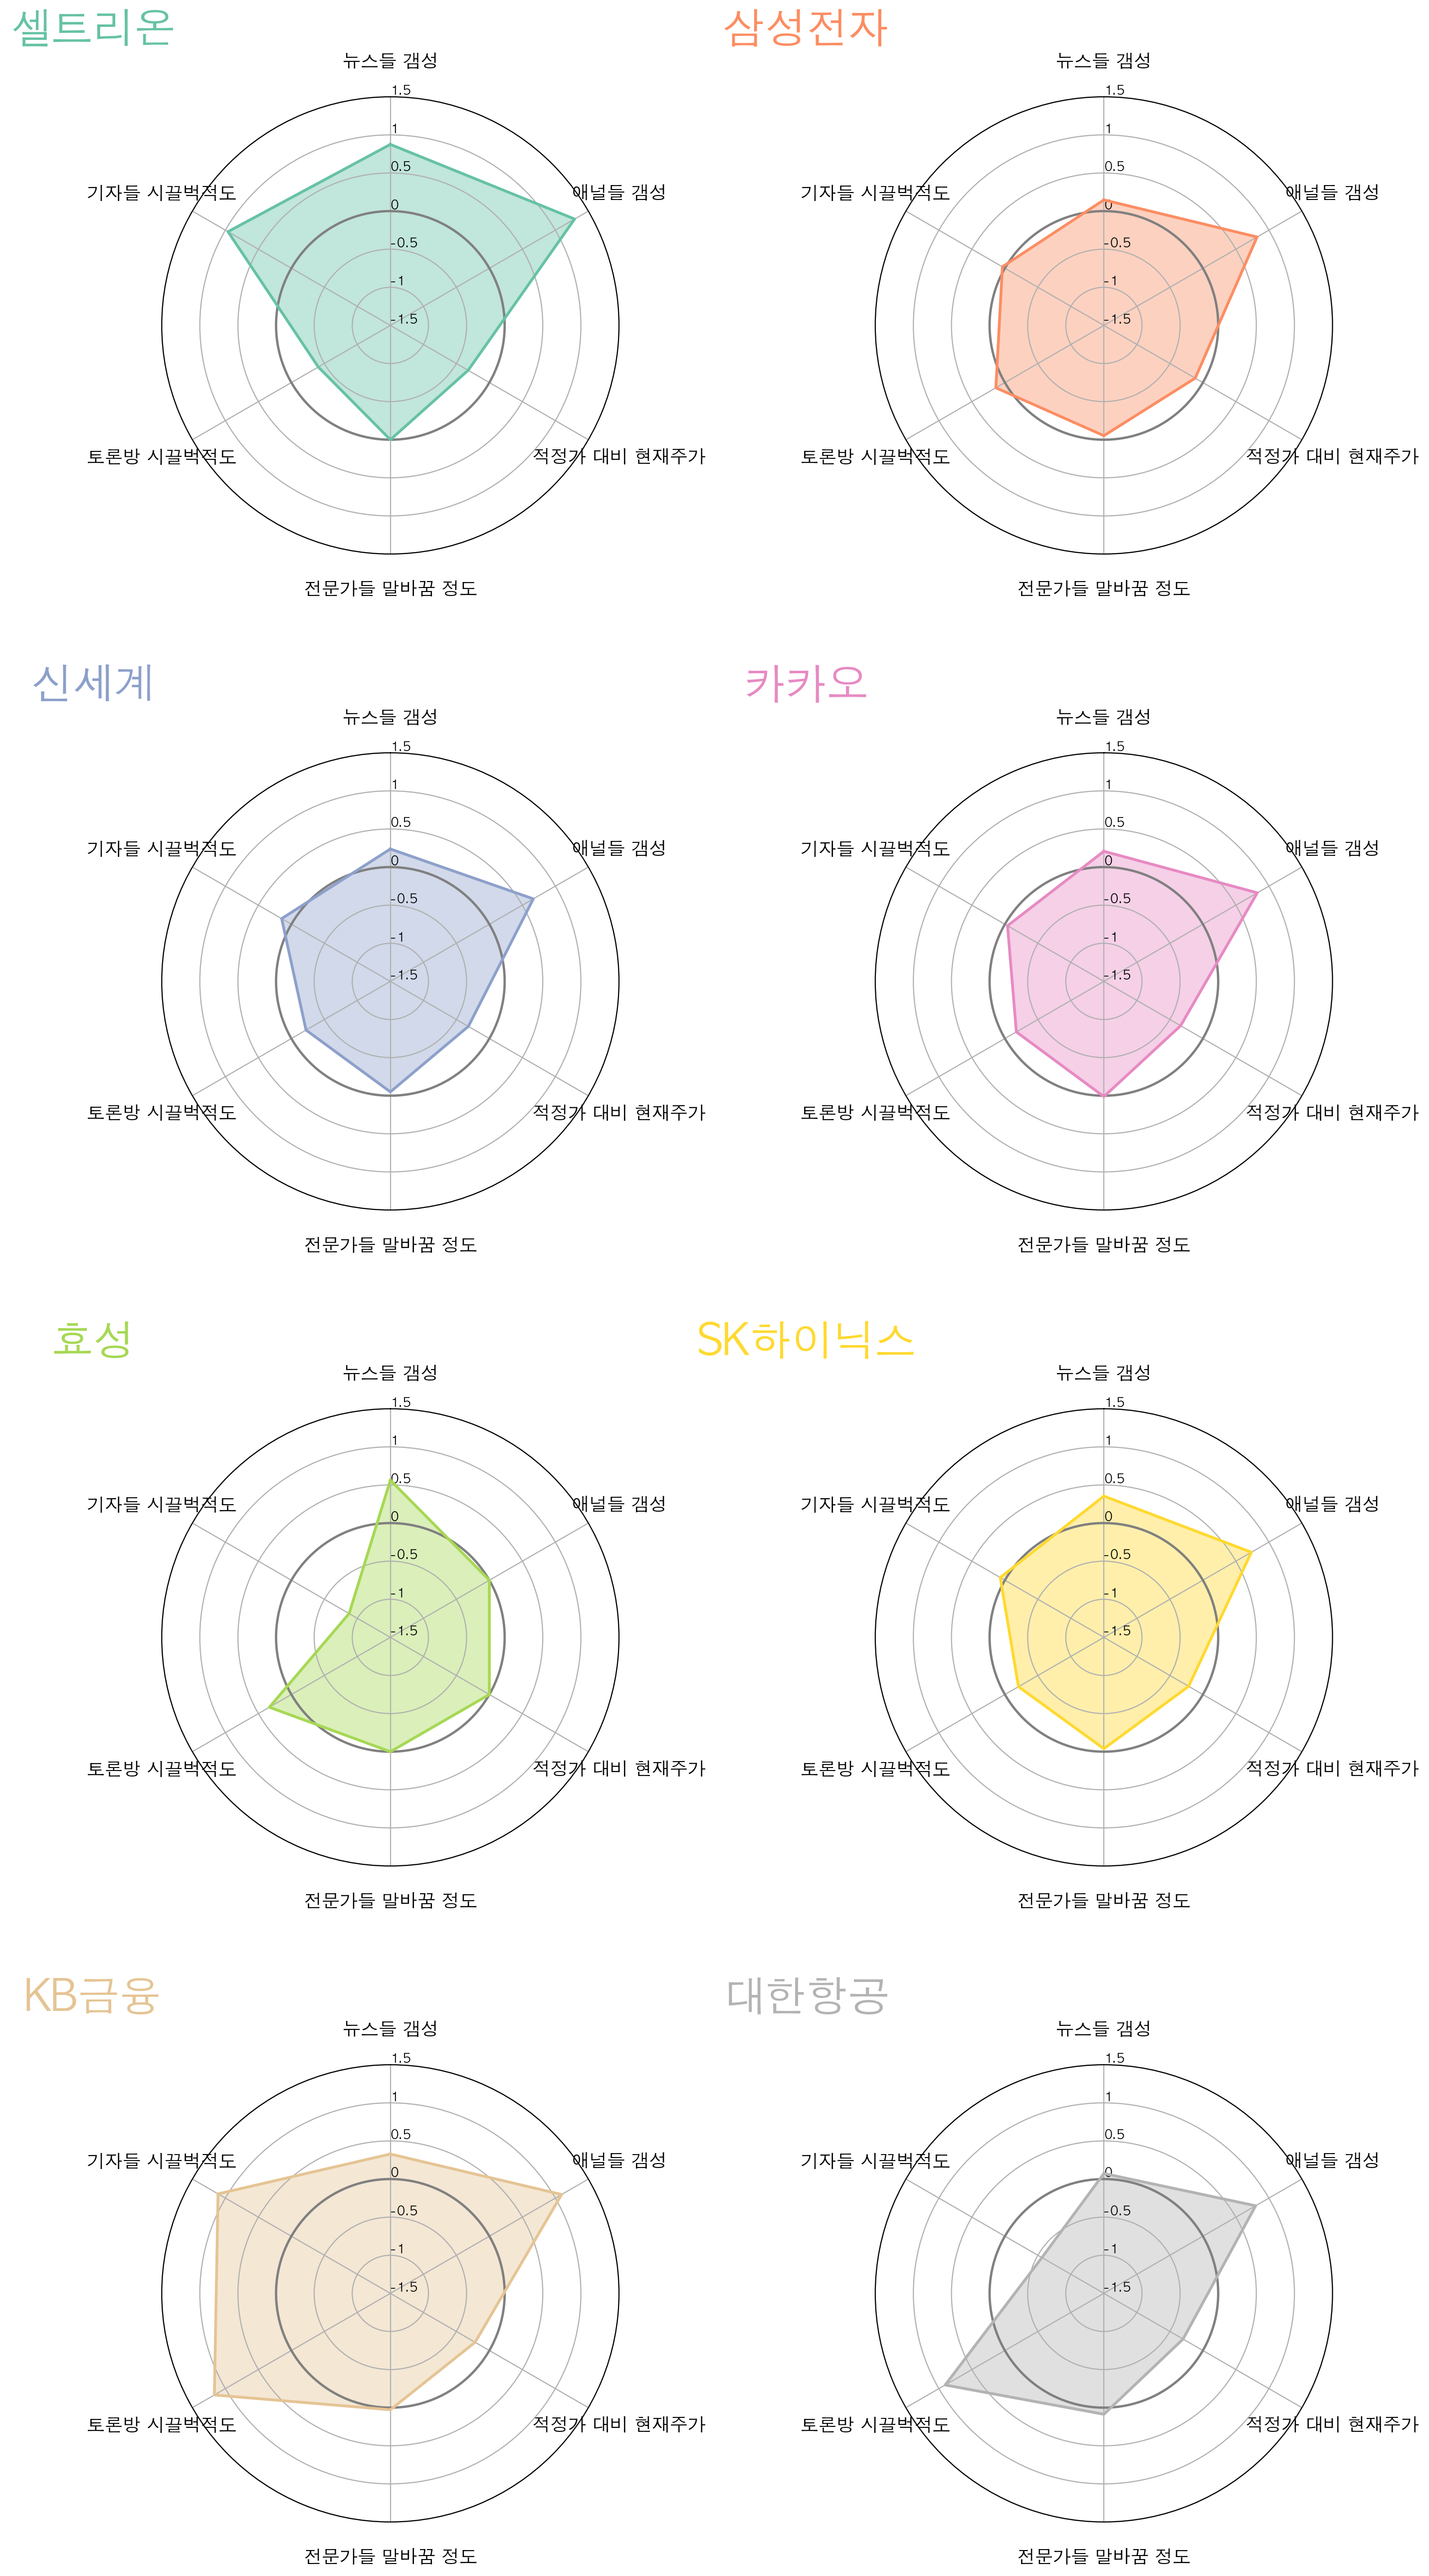

In [77]:
rader_graph(df)

# Total Rader

In [83]:
df['weight'].T @ df[df.columns[4]]

0.3567951339189711

In [107]:
df

,수량,weight,price,yet_ret,snt_news_title_score,snt_consensus_title_score,achievement_ratio,target_change,reply_vol,news_num_change
종목명,,,,,,,,,,
셀트리온,130,0.064972,142500.0,0.010638,0.875310,1.291731,-0.321429,NaN,-0.408138,0.960000
삼성전자,222,0.052634,67600.0,0.019608,0.146902,0.820775,-0.116340,-0.052632,0.136752,0.037915
신세계,89,0.080846,259000.0,0.007782,0.237314,0.666271,-0.318421,-0.050000,-0.222222,0.147059
카카오,888,0.259121,83200.0,0.010936,0.207808,0.824686,-0.337052,0.012097,-0.173913,-0.040000
효성,1000,0.291102,83000.0,0.008505,0.562402,NaN,NaN,NaN,0.333333,-0.875000
SK하이닉스,200,0.078913,112500.0,0.018100,0.353932,0.734333,-0.216028,-0.039063,-0.205607,0.070423
KB금융,288,0.058585,58000.0,-0.011925,0.328216,1.094703,-0.216216,0.027778,1.166667,1.111111
대한항공,1123,0.113827,28900.0,0.000000,0.072781,0.799285,-0.300242,0.086842,0.904762,-0.560976


In [102]:
def total_port_df (port):

    port_weight = port['weight']
    port_cal = port[port.columns[4:]]

    port_idx = ['나의 포트폴리오']

    total_port = pd.DataFrame(index=port_idx, columns=['weight', 'price', 'return'])

    port = port.fillna(0)

    for i in port.columns[4:]:
        
        total_port[i] = [port_weight.T @ port[i]]

    return total_port

In [103]:
total_port_df(df)

,weight,price,return,snt_news_title_score,snt_consensus_title_score,achievement_ratio,target_change,reply_vol,news_num_change
나의 포트폴리오,NaN,NaN,NaN,0.356795,0.607748,-0.203978,0.004752,0.169794,-0.182024


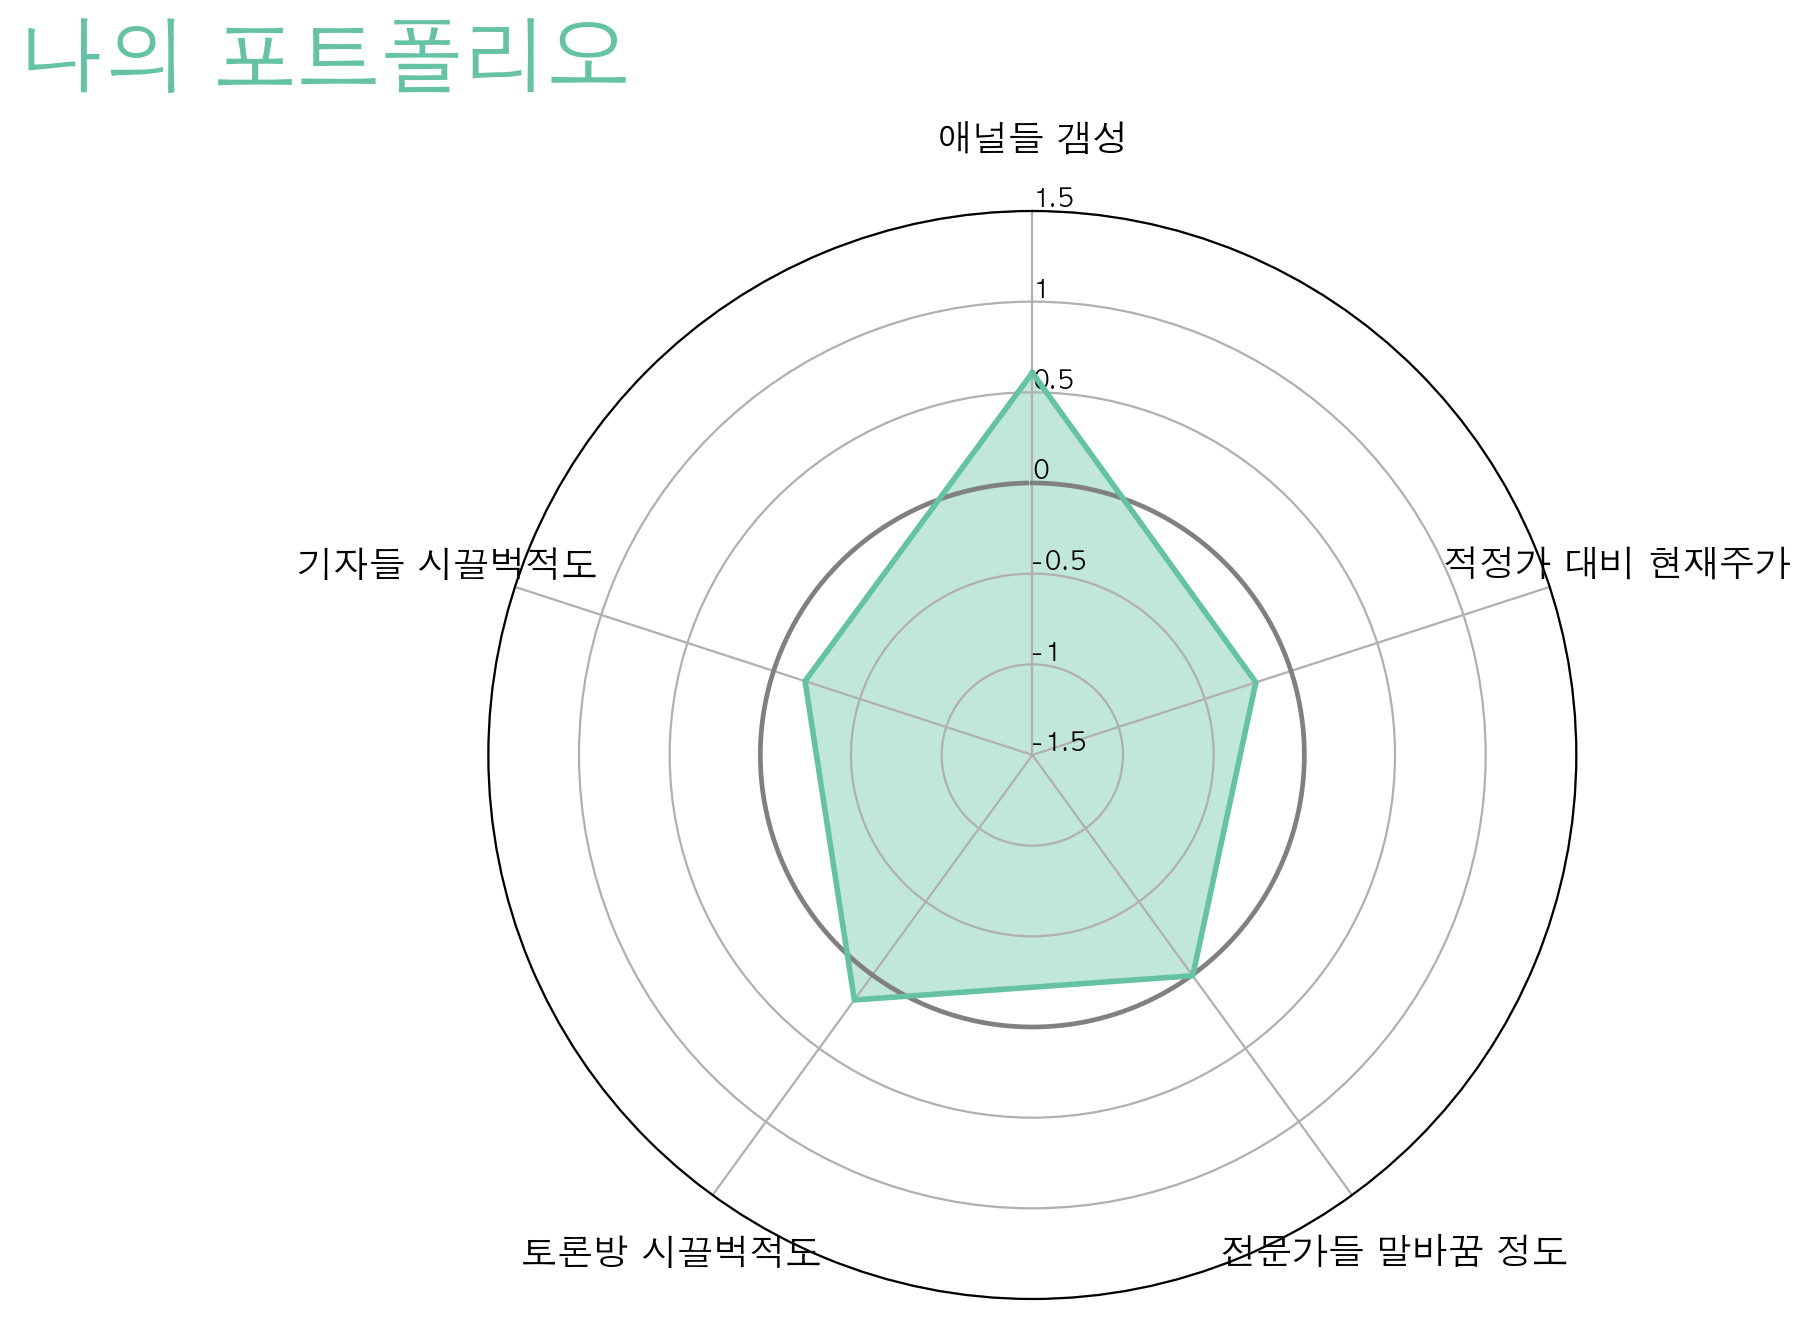

In [104]:
rader_graph(total_port_df(df))

# Wordcloud

In [109]:
from konlpy.tag import Okt
from PIL import Image
from wordcloud import ImageColorGenerator
from wordcloud import WordCloud
from collections import Counter


In [152]:
def return_port_weather_score (port):

    port = port.dropna(axis=1)

    return round((port.T.sum() / len(port.columns)).values[0], 3)

In [ ]:
return_port_weather_score(total_port_df(df))

0.126

In [159]:
def preprocess(date_from, date_to, keyword_list):
    
    buffer = []

    for keyword in keyword_list:
        key = download_total_title_keyword (date_from, date_to, keyword)
        key = sum(key,[])
        

        key=' '.join(s for s in key)
        buffer.append(key)
    
    
    
    return buffer 

def plot_wordcloud(bodies,weight,score=None):

    '''글 '''
    '''
    각 종목들의 기사 body들과 포트폴리오 가중치를 인수로 받아 
    가중치만큼 반영하여 빈도수에 가중하여 워드클라우드로 출력
    '''


    weight = np.array(weight)*1000
    
    np.rint(weight)

    buffer=[]
    
    for i,v in enumerate(bodies):
        okt = Okt()
        noun_list = list(okt.nouns(v))
        pos_list = list(okt.pos(v))
        noun_list=[x for x in noun_list if len(x)>1]

        noun_list*= int(weight[i])

        buffer.append(noun_list)
        
    buffer = sum(buffer,[]) # 리스트의 리스트를 하나의 리스트로 전환
        

    dancing_mask = np.array(Image.open('./wordcloud/psy2.jpg').convert("RGBA"))
    sunny_mask = np.array(Image.open('./wordcloud/sunny.jpg').convert("RGBA"))
    sunny_cloudy_mask = np.array(Image.open('./wordcloud/sunny_clouds.jpg').convert("RGBA"))
    cloudy_mask = np.array(Image.open('./wordcloud/cloud2.png').convert("RGBA"))
    rainy_mask = np.array(Image.open('./wordcloud/raindrop.png').convert("RGBA"))

    if score is None:
        mask = None

    else:
        if score >= 1:
            mask = dancing_mask
            
        elif score >= 0.5:
            mask = sunny_mask
            
        elif score >= 0:
            mask = sunny_cloudy_mask
            
        elif score >= -0.5:
            mask = cloudy_mask
            
        elif score < -0.5:
            mask = rainy_mask        

    if mask is not None:
    
        wordcloud = WordCloud(font_path='./wordcloud/HANYheadM.ttf', mask=mask, width=800, height=800,background_color='white', color_func=ImageColorGenerator(mask))
    
    else:
        wordcloud = WordCloud(font_path='./wordcloud/HANYheadM.ttf', mask=mask, width=800, height=800,background_color='white')


    count = Counter(buffer)
    wordcloud = wordcloud.generate_from_frequencies(count)
    array = wordcloud.to_array()

    fig = plt.figure(figsize=(20,20))
    plt.imshow(array, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    return


def wordcloud_creator_with_keyword (date_from, date_to, keyword_list, weight, score=None):
    
    '''weight는 포트폴리오 웨이트는 리스트로 들어가야댐, Score는 날씨 정보'''

    buffer = preprocess(date_from, date_to, keyword_list)

    plot_wordcloud(buffer, weight, score)



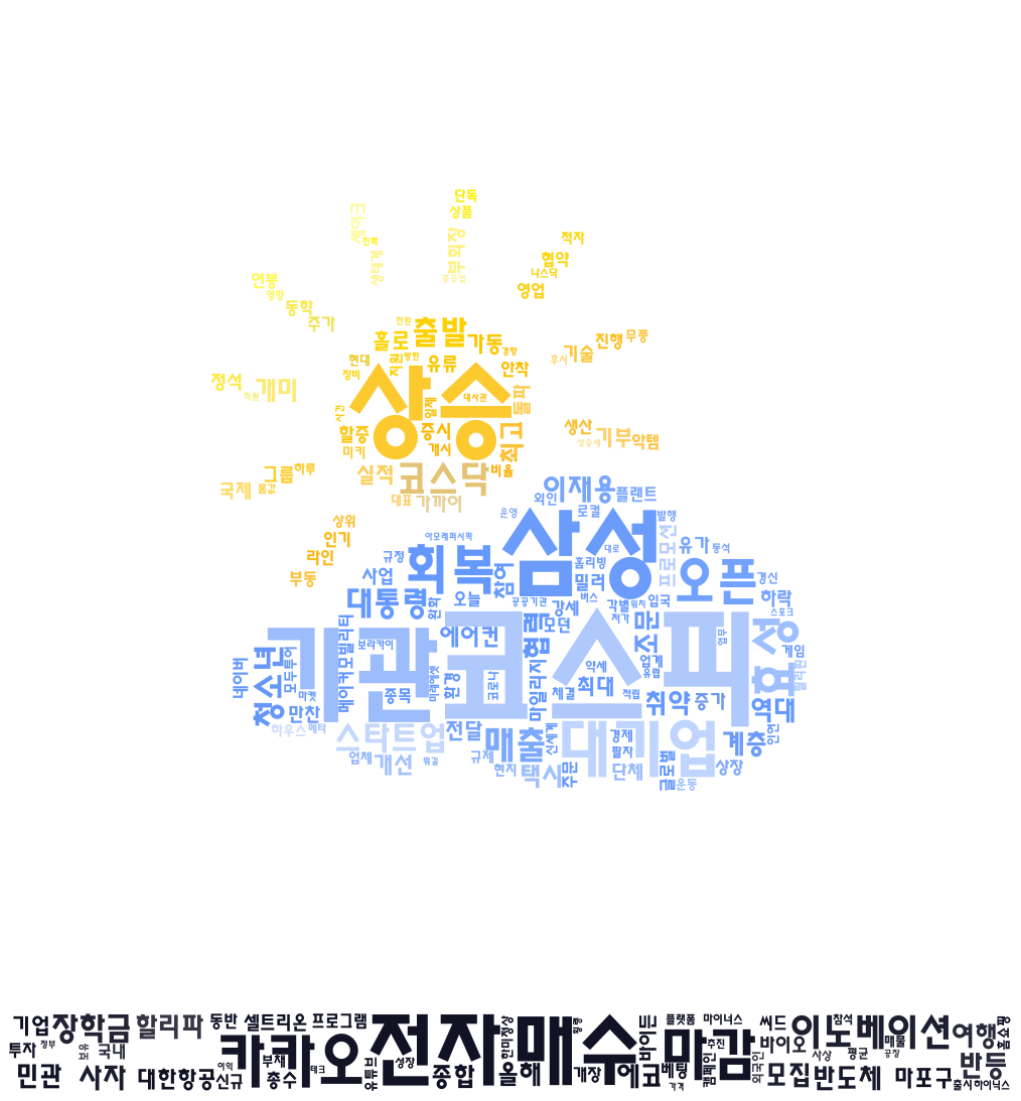

In [160]:
wordcloud_creator_with_keyword("2022-05-17", "2022-05-17", df.index.to_list(), df.weight.to_list(), return_port_weather_score(total_port_df(df)))

# 개판 Sentiment 돌릴거

In [ ]:
OKt(), Hannanum(), 

키워드

키워드

In [ ]:
from konlpy.tag import Hannanum
from config import * # config안의 정보 가져오기
from transformers import pipeline
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras


np.random.seed(1234)
tf.random.set_seed(1234)

model_review = keras.models.load_model('models/best_model_hannanum_review copy.h5')
model_up_down = keras.models.load_model('models/best_model(Okt) copy.h5')


tokenizer = Tokenizer()
han = Hannanum()
classifier = pipeline('sentiment-analysis', model='snunlp/KR-FinBert-SC')

In [ ]:
a = download_total_title_keyword("2022-05-01", "2022-05-02", "삼성전자")

2022-05-01 Start!
***2022-05-01End!***
2022-05-02 Start!
***2022-05-02End!***
Daily Data end!


In [ ]:
len(a)

205

In [ ]:
len(key_list)

7

In [ ]:
key_list = list(set(key_list[0]))

In [ ]:
key_list[0]

'■삼성전자, 멀어지는 시스템반도체 1위\nTSMC·퀄컴 등 시장 확대와 대조\nM&A전문가 영입·선단공정 확보\n분위기 쇄신 박차로 돌파구 모색\n[서울경제]\n삼성전자의 ‘2030년 시스템반도체 1위’ 도전이 쉽지 않다.\n핵심 애플리케이션 프로세서(AP) ‘엑시노스’ 설계부터 파운드리(칩 위탁 생산) 사업까지 사업 확대가 좀처럼 진전되지 못하고 있어서다. 경쟁사의 야성적인 사업 진출과 기술 개발 움직임도 간과할 수 없다. 삼성전자는 고객사 확보와 신규 인수합병(M&A), 기술 초격차에서 돌파구를 찾기 위해 다양한 대책을 세우고 있다.\n2019년 4월 30일 이재용 삼성전자 부회장은 삼성전자 화성캠퍼스에서 열린 선포식에서 “메모리에 이어 파운드리를 포함한 시스템반도체 분야에서도 확실히 1등을 하도록 하겠다”고 선언했다. 당시 행사에 참석했던 문재인 대통령은 “우리의 목표는 분명하다. 2030년까지 시스템반도체 파운드리(위탁 생산) 분야 세계 1위를 달성하는 것”이라고 화답했다.\n3년이 지난 지금 각종 시장 데이터는 삼성전자의 도전이 녹록지 않음을 보여주고 있다.\n시장조사 업체 스트래티지애널리틱스(SA)에 따르면 삼성전자 모바일 AP 시장점유율은 2019년 12.0%에서 지난해 6.6%로 하락했다. 이 분야 강자 퀄컴의 점유율은 2019년 34.8%에서 지난해 37.7%로, 애플은 22.9%에서 26%로 늘어난 것과 대조적이다.\n파운드리 사업에서도 삼성전자의 점유율은 2019년부터 18% 안팎에서 정체된 모양새다. 업계 1위 TSMC는 꾸준히 50% 이상을 유지하면서 점유율을 늘려나가는 추세다. 후발 경쟁자 진입도 매섭다. 지난해 3월 파운드리 사업 재개를 선언하며 업계를 놀라게 한 인텔도 최근 1분기 실적 발표회에서 파운드리 사업부 매출만 분리한 실적(2억 8300만 달러)을 처음 공개하며 존재감을 알렸다.\n이에 삼성 시스템반도체 사업을 향한 우려 섞인 루머가 나오고 있다. 지난달 28일 열렸던 삼성전자 1분기 실적 발표회에서는 파운드리 고객사 이

In [ ]:
# result = classifier(key_list[0:100])

# for i in range(0, len(key_list[0:100])-1):
#     print(f"이 뉴스는 {round(result[i]['score'] * 100, 2)}% 확률로 {result[i]['label']} 입니다.")
#     print(f"제목 : {key_list[i]}\n")

In [ ]:
key_list[0][0][0]

'‘셀트리온’ 집중 매수, 대차잔고 증가[외인이 담은 바이오]'

In [ ]:
def hugging_list (doc_list):

    neutral_num = 0
    positive_num = 0
    negative_num = 0

    for i in doc_list:
        result = classifier(i[0])

        for k in range(0, len(result)-1):
            print(f"이 뉴스는 {round(result[k]['score'] * 100, 2)}% 확률로 {result[k]['label']} 입니다.")
            print(f"제목 : {i[k]}\n")

            if result[i]['label'] == 'neutral':
                neutral_num += 1
            elif result[i]['label'] == 'positive':
                positive_num += 1
            else:
                negative_num += 1


    print(f"neutral : {neutral_num}")
    print(f"positive : {positive_num}")
    print(f"negative : {negative_num}")



In [ ]:
hugging_list(key_list)

neutral : 0
positive : 0
negative : 0


In [ ]:
'''불용어 정리'''
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
#model = keras.models.load_model("./models/best_model(Okt).h5")
#okt = Okt()


def sentiment_predict(new_sentence, model_name):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = han.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = 50) # 패딩
    score = float(model_name.predict(pad_new)) # 예측
    if(score > 0.65):
        print("{:.2f}% 확률로 긍정적입니다.\n".format(score * 100))
    elif (score >0.40):
        print("{:.2f}% 확률로 중립적입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정적입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict("정말 재미있어요", model_review)

59.35% 확률로 중립적입니다.



2022-06-11 02:58:10.973160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-11 02:58:11.030872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
sentiment_predict(key_list[0][0][0], model_review)

59.35% 확률로 중립적입니다.



In [ ]:
sentiment_predict(key_list[0][0][1], model_review)

59.35% 확률로 중립적입니다.



In [ ]:
new_sentence = "2000명 몰렸다…삼성전자 '갤럭시 팬파티' 성료"
new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
new_sentence = han.morphs(new_sentence) # 토큰화
new_sentence
#new_sentence = [word for word in new_sentence if not word in stopwords]

['명', '몰렸다삼성전자', '갤럭시', '팬파티', '성료']

In [ ]:
encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
pad_new = pad_sequences(encoded, maxlen = 30) # 패딩
score = float(model_review.predict(pad_new)) # 예측
score

0.611977756023407

In [ ]:
model_review.predict(['삼성전자 상반기 C랩 스핀오프 론칭데이'])

ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/envs/NLP/lib/python3.8/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/NLP/lib/python3.8/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/NLP/lib/python3.8/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/NLP/lib/python3.8/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/NLP/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/Caskroom/miniforge/base/envs/NLP/lib/python3.8/site-packages/keras/engine/input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 100)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=False
      • mask=None


In [ ]:
key_list[0][0]

'삼성전자 상반기 C랩 스핀오프 론칭데이'

In [ ]:
for i in key_list[0][10:40]:
    sentiment_predict(i, model_name=model_review)

0.611977756023407
61.20% 확률로 긍정적입니다.
AI로 온라인 시험 부정 잡는다..삼성이 지원하는 사내벤처는?

0.611977756023407
61.20% 확률로 긍정적입니다.
삼성전자, hy·삼성카드와 '비스포크 큐커' 할인행사

0.611977756023407
61.20% 확률로 긍정적입니다.
"AI가 시험 감독"…삼성전자, 사내벤처 2곳 '픽'

0.611977756023407
61.20% 확률로 긍정적입니다.
삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인

0.611977756023407
61.20% 확률로 긍정적입니다.
삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인

0.611977756023407
61.20% 확률로 긍정적입니다.
삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인

0.611977756023407
61.20% 확률로 긍정적입니다.
삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인

0.611977756023407
61.20% 확률로 긍정적입니다.
삼성전자, '에듀테크' 관련 C랩 과제 2개 스타트업 창업 지원

0.611977756023407
61.20% 확률로 긍정적입니다.
삼성전자, '에듀테크' 관련 C랩 과제 2개 스타트업 창업 지원

0.611977756023407
61.20% 확률로 긍정적입니다.
韓 반도체, “공급망 재편서 살아남으려면 美 동맹 참여해야”

0.611977756023407
61.20% 확률로 긍정적입니다.
삼성전자, `우리집 전자레인지, 큐커로 교체해요` 2차 캠페인 진행…hy와 협업

0.611977756023407
61.20% 확률로 긍정적입니다.
‘지역화폐 지원’ 삼성페이, 지역경제 활성화 나선다

0.611977756023407
61.20% 확률로 긍정적입니다.
삼성전자 파운드리 출범 5년…공존하는 '기회와 위기'

0.611977756023407
61.20% 확률로 긍정적입니다.
삼성전자, '에듀테크' 관련 

In [ ]:
for i in key_list[0][10:40]:
    sentiment_predict(i, model_name=model_up_down)

50.96% 확률로 부정적입니다.
AI로 온라인 시험 부정 잡는다..삼성이 지원하는 사내벤처는?

50.96% 확률로 부정적입니다.
삼성전자, hy·삼성카드와 '비스포크 큐커' 할인행사

50.96% 확률로 부정적입니다.
"AI가 시험 감독"…삼성전자, 사내벤처 2곳 '픽'

50.96% 확률로 부정적입니다.
삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인

50.96% 확률로 부정적입니다.
삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인

50.96% 확률로 부정적입니다.
삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인

50.96% 확률로 부정적입니다.
삼성전자, hy와 함께 '우리집 전자레인지, 큐커로 교체' 캠페인

50.96% 확률로 부정적입니다.
삼성전자, '에듀테크' 관련 C랩 과제 2개 스타트업 창업 지원

50.96% 확률로 부정적입니다.
삼성전자, '에듀테크' 관련 C랩 과제 2개 스타트업 창업 지원

50.96% 확률로 부정적입니다.
韓 반도체, “공급망 재편서 살아남으려면 美 동맹 참여해야”

50.96% 확률로 부정적입니다.
삼성전자, `우리집 전자레인지, 큐커로 교체해요` 2차 캠페인 진행…hy와 협업

50.96% 확률로 부정적입니다.
‘지역화폐 지원’ 삼성페이, 지역경제 활성화 나선다

50.96% 확률로 부정적입니다.
삼성전자 파운드리 출범 5년…공존하는 '기회와 위기'

50.96% 확률로 부정적입니다.
삼성전자, '에듀테크' 관련 C랩 과제 2개 스타트업 창업 지원

50.96% 확률로 부정적입니다.
"三電, 이재용 부회장 빈자리 크다"…커지는 사면복권 목소리

50.96% 확률로 부정적입니다.
삼성전자, 에듀테크 관련 C랩 과제 2개 스타트업 창업 지원

50.96% 확률로 부정적입니다.
에버랜드에 모인 '갤럭시 찐팬들'…갤S22 팬파티 현장 컴백 '성공적'

50.96% 확률로 부정적입니다.
삼성전자-hy,  '우리집 전자레인지, 큐커로 교체' 캠페인

50.96% 확률

In [ ]:
하이아아하이아히아히아아아아